In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt
from pathlib import Path

### Load and describe data

In [2]:
data = pd.read_csv(str(Path("../data/interim/regularized.csv")), 
                   parse_dates=True, infer_datetime_format=True, index_col=0)
stats = data.describe(include='all')
stats.loc['IQR'] = (stats.loc['75%'] - stats.loc['25%'])
stats.loc['low'] = stats.loc['25%'] - (1.5 * stats.loc['IQR'])
stats.loc['high'] = stats.loc['75%'] + (1.5 * stats.loc['IQR'])
stats.loc['outliers'] = (stats.loc['min'] < stats.loc['low']) | (stats.loc['max'] > stats.loc['high'])
stats.loc['outliers'] = (stats.loc['outliers']).map(bool)
stats

,DA_Demand,RT_Demand,DA_LMP,DA_EC,DA_CC,DA_MLC,RT_LMP,RT_EC,RT_CC,RT_MLC,Dry_Bulb,Dew_Point,System_Load,Reg_Service_Price,Reg_Capacity_Price
count,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560,25560
mean,0.352375,0.322117,0.110651,0.112364,0.916365,0.172105,0.0732869,0.0733841,0.6769,0.157795,0.596226,0.656381,0.320514,0.0340485,0.0121081
std,0.152717,0.157806,0.0789266,0.0796483,0.0154353,0.0511594,0.0151186,0.0150627,0.0173923,0.0317001,0.177179,0.196823,0.158146,0.0866514,0.0168026
min,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25%,0.24214,0.209522,0.0682393,0.069201,0.917559,0.149648,0.0673827,0.0674792,0.67628,0.144408,0.457143,0.515152,0.208082,0.005,0.00488516
50%,0.341039,0.313114,0.0890486,0.0905107,0.917559,0.161972,0.0699875,0.0701035,0.67628,0.152009,0.6,0.676768,0.310926,0.017,0.00748
75%,0.437468,0.410416,0.124262,0.126397,0.9177,0.179577,0.0750323,0.0752263,0.67638,0.161781,0.742857,0.818182,0.408768,0.025,0.0135403
max,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
IQR,0.195328,0.200894,0.0560225,0.0571964,0.000140924,0.0299296,0.00764955,0.00774712,9.9453e-05,0.0173724,0.285714,0.30303,0.200687,0.02,0.00865519
low,-0.0508519,-0.0918199,-0.0157944,-0.0165936,0.917348,0.104754,0.0559084,0.0558585,0.676131,0.11835,0.0285714,0.0606061,-0.0929485,-0.025,-0.00809762


### Look for features with high correlation

In [3]:
correlations = data.corr()
mask = correlations.applymap(lambda x : x < 1.0 and x > 0.95)
high_corr = correlations[mask].dropna(how='all', axis=1).dropna(how='all', axis=0)
high_corr_features = high_corr.columns
high_corr

,DA_Demand,RT_Demand,DA_LMP,DA_EC,RT_LMP,RT_EC,System_Load
DA_Demand,NaN,0.976353,NaN,NaN,NaN,NaN,0.976348
RT_Demand,0.976353,NaN,NaN,NaN,NaN,NaN,0.999922
DA_LMP,NaN,NaN,NaN,0.999007,NaN,NaN,NaN
DA_EC,NaN,NaN,0.999007,NaN,NaN,NaN,NaN
RT_LMP,NaN,NaN,NaN,NaN,NaN,0.998976,NaN
RT_EC,NaN,NaN,NaN,NaN,0.998976,NaN,NaN
System_Load,0.976348,0.999922,NaN,NaN,NaN,NaN,NaN


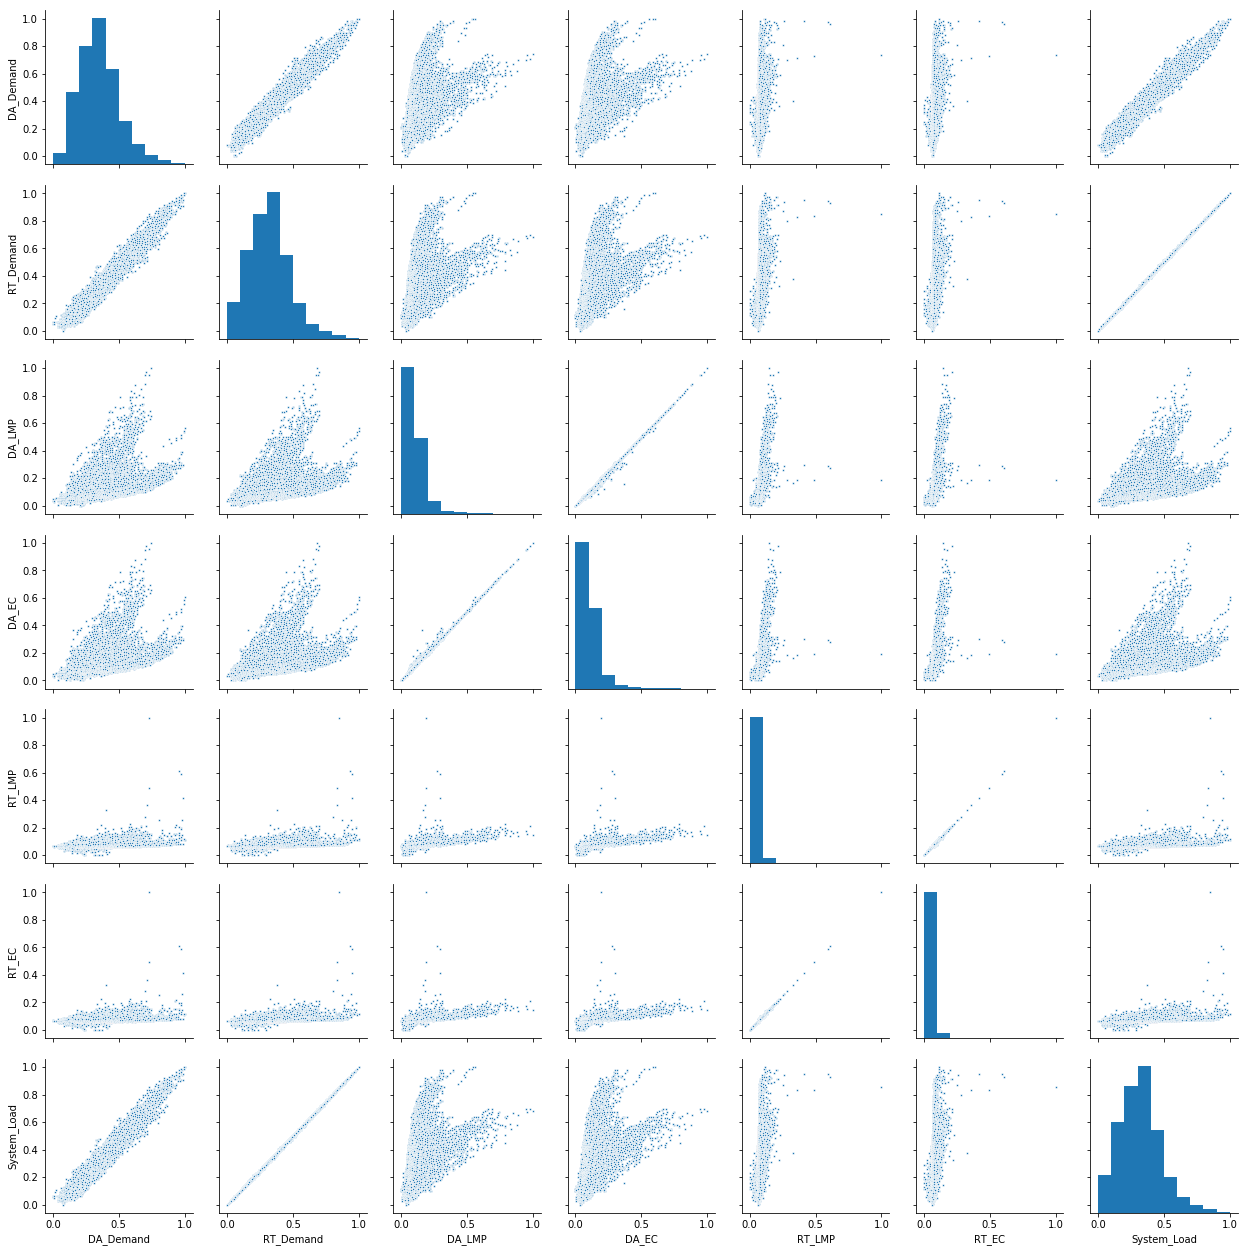

In [77]:
sns.pairplot(data[high_corr_features], plot_kws={"s":6})
plt.show()

In [4]:
# Drop high correlation features because values are nearly the same and thus redundant.
# - Real Time Demand since it is almost identical to the target, System Load.
# - Locational Marginal Price (LMP) since it is highly correlated with EC. Plus EC, CC, and MLC are derivatives of LMP.
no_high_corr_data = data.drop(columns=['RT_Demand', 'DA_LMP', 'RT_LMP'])

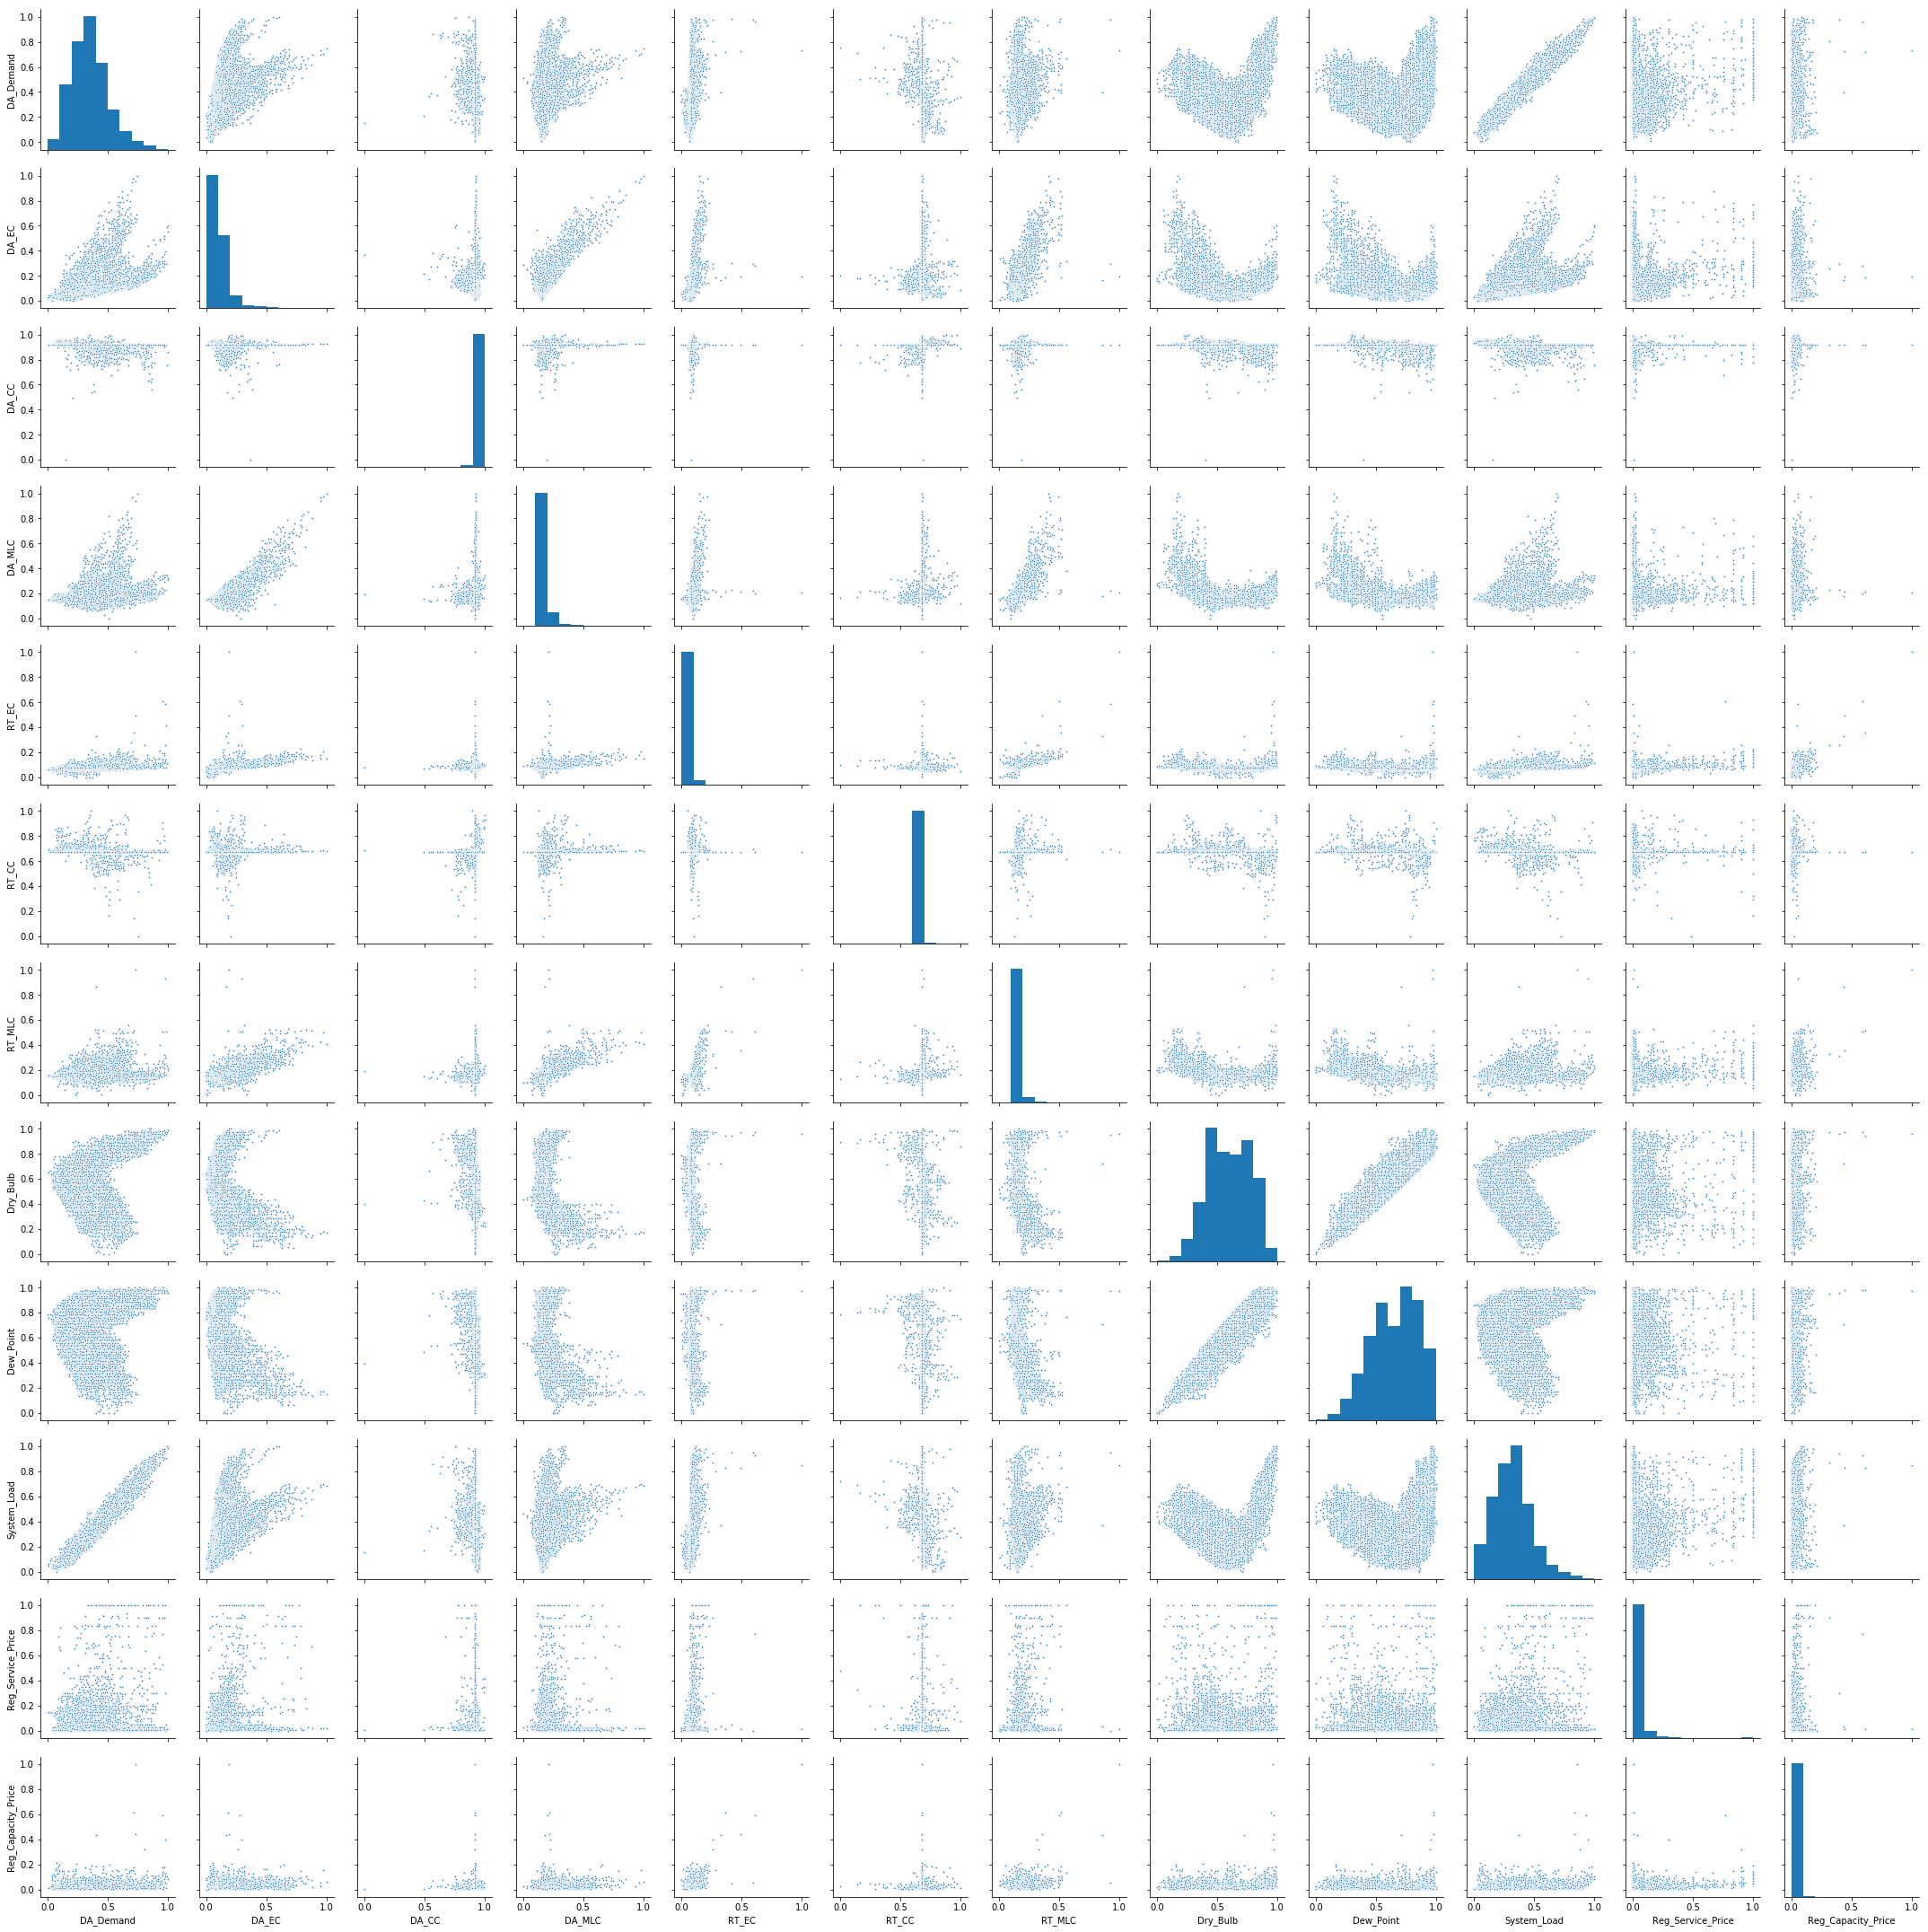

In [79]:
sns.pairplot(no_high_corr_data, plot_kws={"s":6})
plt.show()

### Look for features with low variance

In [6]:
no_high_corr_stats = no_high_corr_data.describe(include='all')
no_high_corr_stats.loc[:, no_high_corr_stats.loc['std'] < 0.02]

,DA_CC,RT_EC,RT_CC,Reg_Capacity_Price
count,25560.000000,25560.000000,25560.000000,25560.000000
mean,0.916365,0.073384,0.676900,0.012108
std,0.015435,0.015063,0.017392,0.016803
min,0.000000,0.000000,0.000000,0.000000
25%,0.917559,0.067479,0.676280,0.004885
50%,0.917559,0.070104,0.676280,0.007480
75%,0.917700,0.075226,0.676380,0.013540
max,1.000000,1.000000,1.000000,1.000000


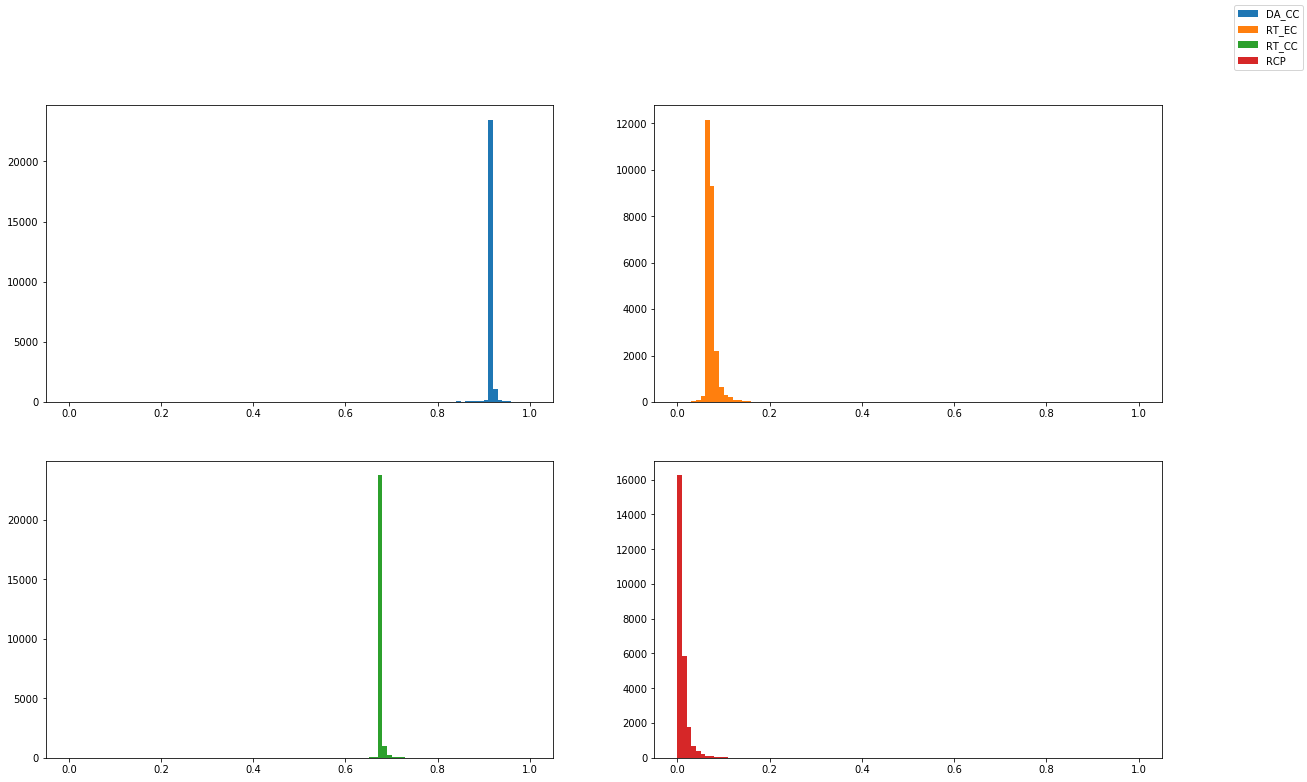

In [7]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,12))
ax1.hist(no_high_corr_data['DA_CC'], bins=100, label='DA_CC', color='C0')
ax2.hist(no_high_corr_data['RT_EC'], bins=100, label='RT_EC', color='C1')
ax3.hist(no_high_corr_data['RT_CC'], bins=100, label='RT_CC', color='C2')
ax4.hist(no_high_corr_data['Reg_Capacity_Price'], bins=100, label='RCP', color='C3')
fig.legend()
plt.show()

In [8]:
# Drop low variance features because values are nearly constant and thus uninformative.
# Drop Congestion Component (CC) columns (bin with >20000 counts)
no_low_var_data = no_high_corr_data.drop(columns=['DA_CC', 'RT_CC'])

In [9]:
# Remaining features after filtering
for feature in no_low_var_data.columns:
    print(feature)

DA_Demand
DA_EC
DA_MLC
RT_EC
RT_MLC
Dry_Bulb
Dew_Point
System_Load
Reg_Service_Price
Reg_Capacity_Price


### Look for features to transform

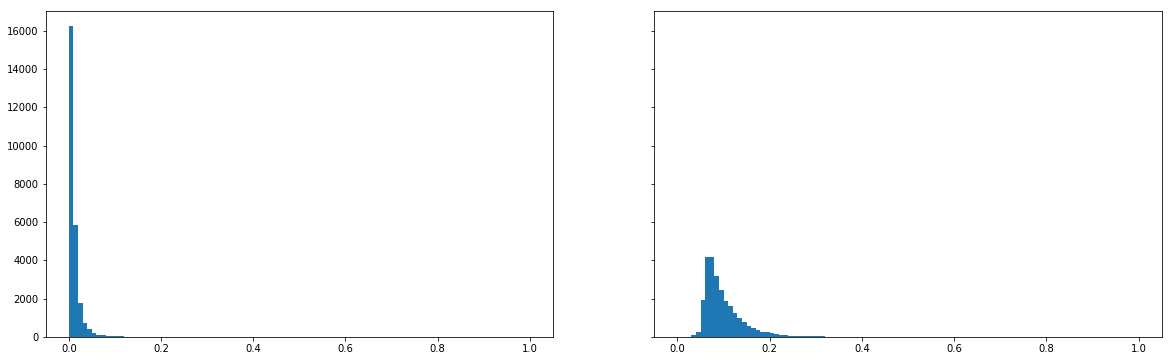

In [10]:
# In pairplot above, we see many skewed features. We can spread the values out more with transformations.
# Since data is non-negative and right-skewed, apply square or "quarter" root function.

def qtrt(x):
    return x ** 0.25

# Go through features above and determine whether transformation is appropriate.
feat = 'Reg_Capacity_Price'
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,6),sharey=True)
ax1.hist(no_low_var_data[feat], bins=100)
ax2.hist(sqrt(no_low_var_data[feat]), bins=100)
plt.show()

In [11]:
# After inspecting all the features, make the following transformations:
feat_to_sqrt = ['DA_EC', 'DA_MLC', 'RT_MLC', 'Reg_Service_Price', 'Reg_Capacity_Price']
feat_to_qtrt = ['RT_EC']
trans_data = no_low_var_data.copy()
for feat in feat_to_sqrt:
    trans_data[feat] = sqrt(trans_data[feat])
for feat in feat_to_qtrt:
    trans_data[feat] = qtrt(trans_data[feat])

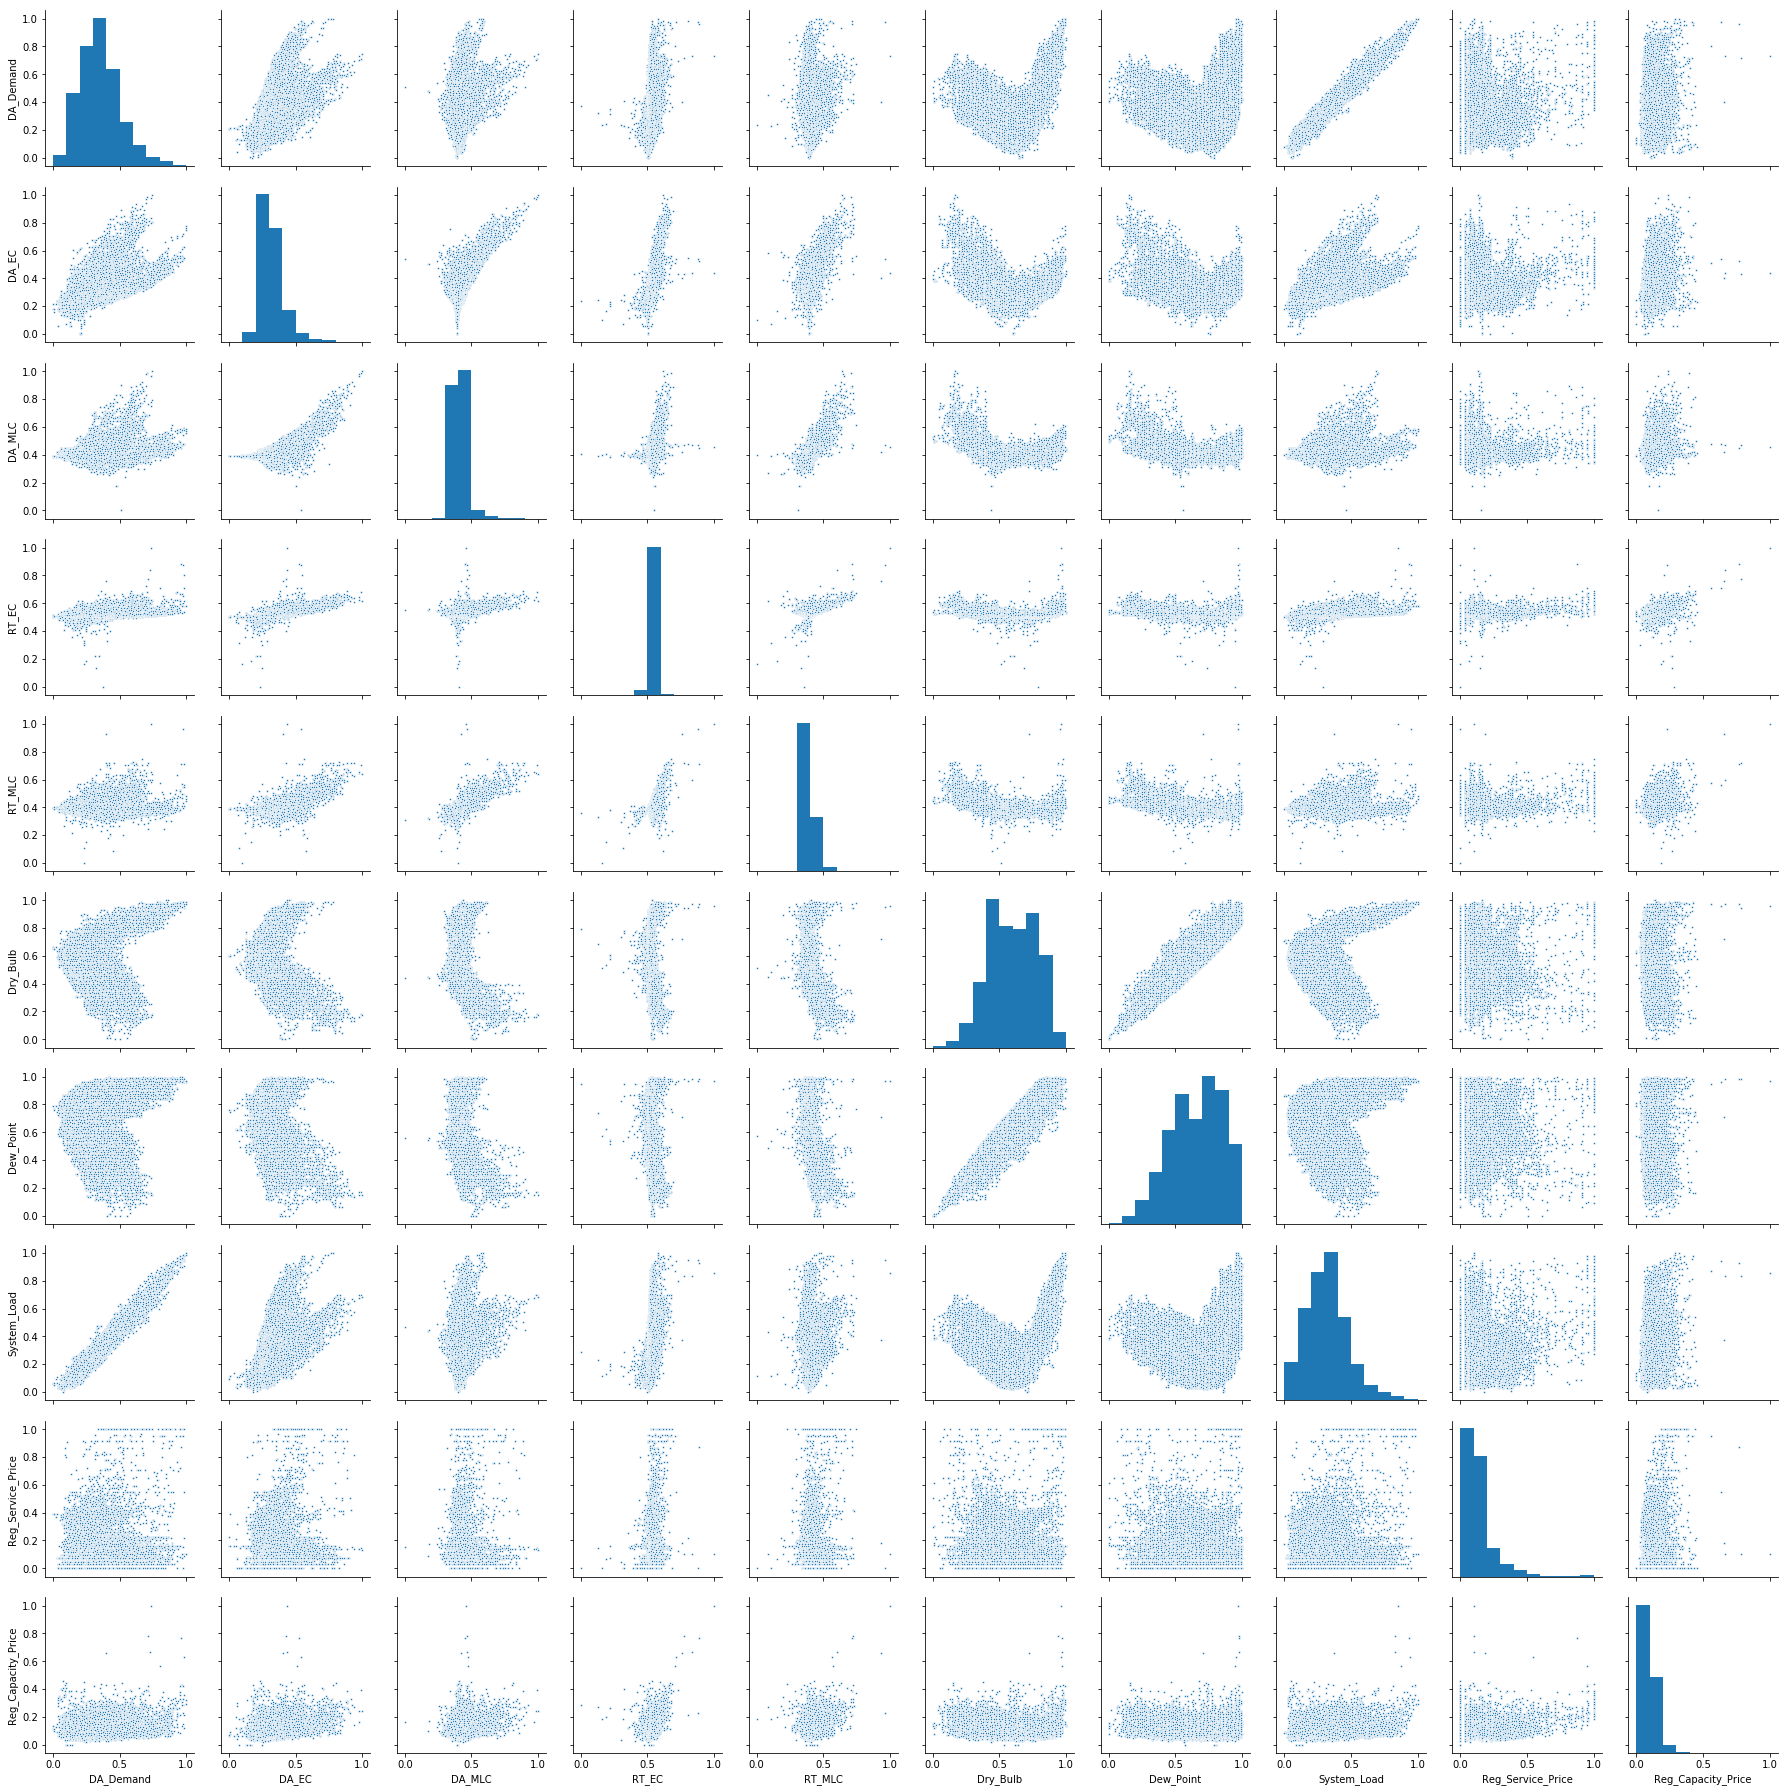

In [166]:
sns.pairplot(trans_data, plot_kws={"s":6})
plt.show()